In [1]:
%cd Workspace/Jupyter/go-it-dl-nlp

/home/vdubyna/Workspace/Jupyter/go-it-dl-nlp


In [2]:
!python -m spacy download en_core_web_sm
!python -m spacy download it_core_news_sm

/home/vdubyna/miniconda3/envs/ai/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 4.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
/home/vdubyna/miniconda3/envs/ai/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 10.2 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')


In [3]:
import spacy

spacy.load('it_core_news_sm')
spacy.load('en_core_web_sm')


/home/vdubyna/miniconda3/envs/ai/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [4]:
import spacy
import datasets
import en_core_web_sm
import it_core_news_sm

# import torchtext

import torch
import torch.nn as nn
import torch.optim as optim

import evaluate

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import os
import random
from tqdm.auto import tqdm
from dataclasses import dataclass

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [5]:
dataset = datasets.load_dataset("Helsinki-NLP/europarl", name="en-it")

In [6]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 1946253
    })
})

In [8]:
# 1. Взяти 2% випадково
small_data = dataset["train"].train_test_split(test_size=0.98, seed=42)["train"]

# 2. Розбити на train / validation / test
split = small_data.train_test_split(test_size=0.1, seed=42)
train_data = split["train"]
test_data = split["test"]

In [9]:
train_data.shape

(35032, 1)

In [10]:
en_nlp = en_core_web_sm.load()
it_nlp = it_core_news_sm.load()

In [11]:
# Збір довжин токенізованих речень (приклад для перших 10_000 рядків)
sample_size = 10_000
lengths = [
    len(en_nlp(example["translation"]["en"]))
    for example in train_data.select(range(sample_size))
]

# Обчислення 95-го перцентиля
percentile_95 = int(np.percentile(lengths, 95))
print(f"95-й перцентиль довжини (в токенах): {percentile_95}")

95-й перцентиль довжини (в токенах): 60


In [12]:
def tokenize_example(
    example,
    en_nlp,
    it_nlp,
    max_length,
    lower,
    sos_token,
    eos_token
):
    '''
    Tokenizes a textual English-Italian input pair.
    Args:
        example: (dict) a dictionary with one phrase in English and Italian; keys 'en', 'it'
        en_nlp: (spacy.lang) a spacy language model for English
        it_nlp: (spacy.lang) a spacy language model for Italian
        max_length: (int) max input sentence length, symbols
        lower: (bool) if to lowercase input
        sos_token: (str) a start_of_sequence token
        eos_token: (str) an end_of_sequence token

    Return:
        (dict) pre-processed and tokenized input sequence
    '''
    en_tokens = [token.text for token in en_nlp.tokenizer(example["translation"]["en"])][:max_length]
    it_tokens = [token.text for token in it_nlp.tokenizer(example["translation"]["it"])][:max_length]
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        it_tokens = [token.lower() for token in it_tokens]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    it_tokens = [sos_token] + it_tokens + [eos_token]
    return {"en_tokens": en_tokens, "it_tokens": it_tokens}

In [13]:
# Pre-process input data

# max_length = 1_000
# Більшість речень мають по 60 токенів тому я виставив максимум 80 щоб ігнорувати потенційні викиди
max_length = 80
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp,
    "it_nlp": it_nlp,
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
# valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/3893 [00:00<?, ? examples/s]

In [14]:
train_data[0]

{'translation': {'en': 'However, there are some aspects in the report which need clarifying.',
  'it': 'Vi sono tuttavia alcuni aspetti nella relazione che debbono essere chiariti.'},
 'en_tokens': ['<sos>',
  'however',
  ',',
  'there',
  'are',
  'some',
  'aspects',
  'in',
  'the',
  'report',
  'which',
  'need',
  'clarifying',
  '.',
  '<eos>'],
 'it_tokens': ['<sos>',
  'vi',
  'sono',
  'tuttavia',
  'alcuni',
  'aspetti',
  'nella',
  'relazione',
  'che',
  'debbono',
  'essere',
  'chiariti',
  '.',
  '<eos>']}

In [15]:
# import torchtext - Не працює на Apple M1
# Замінюєм функціонал
from collections import Counter, defaultdict
from typing import List, Dict

from collections import Counter
from typing import List, Dict

class Vocab:
    def __init__(self, counter: Counter, specials: List[str] = None, min_freq: int = 1):
        if specials is None:
            specials = []

        self.token_to_id: Dict[str, int] = {}
        self.id_to_token: Dict[int, str] = {}
        self.default_index: int = 0  # Default fallback index

        # Додаємо special tokens
        idx = 0
        for token in specials:
            self.token_to_id[token] = idx
            self.id_to_token[idx] = token
            idx += 1

        # Додаємо звичайні токени
        for token, freq in counter.items():
            if freq >= min_freq and token not in self.token_to_id:
                self.token_to_id[token] = idx
                self.id_to_token[idx] = token
                idx += 1

    def __getitem__(self, token: str) -> int:
        return self.token_to_id.get(token, self.default_index)

    def lookup_token(self, index: int) -> str:
        return self.id_to_token.get(index, "<unk>")

    def lookup_tokens(self, indices: List[int]) -> List[str]:
        return [self.lookup_token(index) for index in indices]

    def __len__(self) -> int:
        return len(self.token_to_id)

    def get_stoi(self) -> Dict[str, int]:
        return self.token_to_id

    def get_itos(self) -> Dict[int, str]:
        return self.id_to_token

    def set_default_index(self, index: int):
        self.default_index = index

    def lookup_indices(self, tokens: List[str]) -> List[int]:
        return [self[token] for token in tokens]


In [16]:
from collections import Counter

special_tokens = ["<unk>", "<pad>", "<sos>", "<eos>"]
min_freq = 2
unk_token = "<unk>" # unknown token
pad_token = "<pad>" # padding token

# Створення лічильника токенів
en_counter = Counter(token for tokens in train_data["en_tokens"] for token in tokens)
it_counter = Counter(token for tokens in train_data["it_tokens"] for token in tokens)

# Побудова словників
en_vocab = Vocab(en_counter, specials=special_tokens, min_freq=min_freq)
it_vocab = Vocab(it_counter, specials=special_tokens, min_freq=min_freq)            # розмір словника

In [17]:
assert en_vocab[unk_token] == it_vocab[unk_token]
assert en_vocab[pad_token] == it_vocab[pad_token]

unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

print(unk_index)
print(pad_index)
print(en_vocab['the'])

0
1
11


In [18]:
en_vocab.set_default_index(unk_index)
it_vocab.set_default_index(unk_index)

In [19]:
def numericalize_example(example, en_vocab, it_vocab):
    '''
    Creates a mapping from string tokens to the vocabulary indexes.
    '''
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    it_ids = it_vocab.lookup_indices(example["it_tokens"])
    return {"en_ids": en_ids, "it_ids": it_ids}

In [20]:
example = en_vocab.lookup_indices(random.choice(train_data)["en_tokens"])
example

[2,
 11,
 286,
 3015,
 52,
 30,
 43,
 1501,
 13,
 177,
 5,
 43,
 305,
 5,
 61,
 21,
 3899,
 1089,
 5,
 304,
 10,
 992,
 24,
 2871,
 978,
 16,
 3]

In [21]:
fn_kwargs = {
    "en_vocab": en_vocab,
    "it_vocab": it_vocab
}

train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
# valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/35032 [00:00<?, ? examples/s]

Map:   0%|          | 0/3893 [00:00<?, ? examples/s]

In [22]:
train_data[0]

{'translation': {'en': 'However, there are some aspects in the report which need clarifying.',
  'it': 'Vi sono tuttavia alcuni aspetti nella relazione che debbono essere chiariti.'},
 'en_tokens': ['<sos>',
  'however',
  ',',
  'there',
  'are',
  'some',
  'aspects',
  'in',
  'the',
  'report',
  'which',
  'need',
  'clarifying',
  '.',
  '<eos>'],
 'it_tokens': ['<sos>',
  'vi',
  'sono',
  'tuttavia',
  'alcuni',
  'aspetti',
  'nella',
  'relazione',
  'che',
  'debbono',
  'essere',
  'chiariti',
  '.',
  '<eos>'],
 'en_ids': [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 3],
 'it_ids': [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 3]}

In [23]:
# Data to torch Dataset format

data_type = "torch"
format_columns = ["en_ids", "it_ids"]

train_data = train_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True
)

test_data = test_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

In [24]:
train_data

Dataset({
    features: ['translation', 'en_tokens', 'it_tokens', 'en_ids', 'it_ids'],
    num_rows: 35032
})

In [25]:
train_data[0]

{'en_ids': tensor([ 2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,  3]),
 'it_ids': tensor([ 2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  3]),
 'translation': {'en': 'However, there are some aspects in the report which need clarifying.',
  'it': 'Vi sono tuttavia alcuni aspetti nella relazione che debbono essere chiariti.'},
 'en_tokens': ['<sos>',
  'however',
  ',',
  'there',
  'are',
  'some',
  'aspects',
  'in',
  'the',
  'report',
  'which',
  'need',
  'clarifying',
  '.',
  '<eos>'],
 'it_tokens': ['<sos>',
  'vi',
  'sono',
  'tuttavia',
  'alcuni',
  'aspetti',
  'nella',
  'relazione',
  'che',
  'debbono',
  'essere',
  'chiariti',
  '.',
  '<eos>']}

In [26]:
def get_collate_fn(pad_index):
    '''
    Adding padding as a part of a collate_fn.
    '''

    def collate_fn(batch):
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_it_ids = [example["it_ids"] for example in batch]
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_it_ids = nn.utils.rnn.pad_sequence(batch_it_ids, padding_value=pad_index)
        batch = {
            "en_ids": batch_en_ids,
            "it_ids": batch_it_ids,
        }
        return batch

    return collate_fn

In [27]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):

    collate_fn = get_collate_fn(pad_index)

    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )

    return data_loader

In [28]:
batch_size = 128
train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [29]:
next(iter(train_data_loader))

{'en_ids': tensor([[  2,   2,   2,  ...,   2,   2,   2],
         [  4,   8, 173,  ...,   4, 159,  68],
         [  5,  90, 378,  ...,   5, 835, 374],
         ...,
         [  1,   1,   1,  ...,   1,   1,   1],
         [  1,   1,   1,  ...,   1,   1,   1],
         [  1,   1,   1,  ...,   1,   1,   1]]),
 'it_ids': tensor([[   2,    2,    2,  ...,    2,    2,    2],
         [ 318,    6,  438,  ...,  990,  197,  124],
         [1623,   30,  437,  ...,  773,   30,  431],
         ...,
         [   1,    1,    1,  ...,    1,    1,    1],
         [   1,    1,    1,  ...,    1,    1,    1],
         [   1,    1,    1,  ...,    1,    1,    1]])}

In [30]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, encoder_hidden_dim, bidirectional = True)
        self.fc = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src): # (src_length, batch size)
        embedded = self.dropout(self.embedding(src)) # (src_length, batch_size, embedding_dim)

        outputs, hidden = self.rnn(embedded)
        # outputs (src_length, batch_size, hidden dim * n_directions)
        # hidden (n_layers * n_directions, batch_size, hidden dim)

        # hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]

        # outputs are always from the last layer
        # hidden [-2, :, : ] is the last of the forwards RNN
        # hidden [-1, :, : ] is the last of the backwards RNN

        # initial decoder hidden is final hidden state of the forwards and backwards
        # encoder RNNs fed through a linear layer

        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))

        # outputs (src_length, batch_size, encoder_hidden_dim * 2)
        # hidden (batch_size, decoder_hidden_dim)

        return outputs, hidden

In [31]:
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.attn_fc = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim,
            decoder_hidden_dim
        )
        self.v_fc = nn.Linear(decoder_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden (batch_size, decoder_hidden_dim)
        # encoder_outputs (src_length, batch_size, encoder_hidden dim * 2)

        batch_size = encoder_outputs.shape[1]
        src_length = encoder_outputs.shape[0]

        # repeat decoder hidden state src_length times
        hidden = hidden.unsqueeze(1).repeat(1, src_length, 1) # (batch_size, src_length, decoder_hidden_dim)
        encoder_outputs = encoder_outputs.permute(1, 0, 2) # (batch_size, src_length, encoder_hidden_dim * 2)

        energy = torch.tanh(self.attn_fc(torch.cat((hidden, encoder_outputs), dim=2)))
        # (batch_size, src_length, decoder_hidden_dim)

        attention = self.v_fc(energy).squeeze(2) # batch_size, src_length

        return torch.softmax(attention, dim=1)

In [32]:
class Decoder(nn.Module):
    def __init__(
        self,
        output_dim,
        embedding_dim,
        encoder_hidden_dim,
        decoder_hidden_dim,
        attention,
        dropout=0.3
    ):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.GRU((encoder_hidden_dim * 2) + embedding_dim, decoder_hidden_dim)
        self.fc_out = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim + embedding_dim,
            output_dim
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        # input = (batch_size)
        # hidden = batch_size, decoder hidden dim]
        # encoder_outputs = [src length, batch size, encoder hidden dim * 2]
        input = input.unsqueeze(0)
        # input = [1, batch size]
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, embedding dim]
        a = self.attention(hidden, encoder_outputs)
        # a = [batch size, src length]
        a = a.unsqueeze(1)
        # a = [batch size, 1, src length]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs = [batch size, src length, encoder hidden dim * 2]
        weighted = torch.bmm(a, encoder_outputs) # batch matrix-matrix product
        # weighted = [batch size, 1, encoder hidden dim * 2]
        weighted = weighted.permute(1, 0, 2)
        # weighted = [1, batch size, encoder hidden dim * 2]
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        # rnn_input = [1, batch size, (encoder hidden dim * 2) + embedding dim]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        # output = [seq length, batch size, decoder hid dim * n directions]
        # hidden = [n layers * n directions, batch size, decoder hid dim]
        # seq len, n layers and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, decoder hidden dim]
        # hidden = [1, batch size, decoder hidden dim]
        # this also means that output == hidden
        assert (output == hidden).all()
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        #prediction = [batch size, output dim]
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [33]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio):
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        batch_size = src.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        # encoder_outputs is all hidden states of the input sequence, back and forwards
        # hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
        # outputs = [src length, batch size, encoder hidden dim * 2]
        # hidden = [batch size, decoder hidden dim]
        # first input to the decoder is the <sos> tokens
        input = trg[0,:]
        for t in range(1, trg_length):
            # insert input token embedding, previous hidden state and all encoder hidden states
            # receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            # output = [batch size, output dim]
            # hidden = [n layers, batch size, decoder hidden dim]
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            #get the highest predicted token from our predictions
            top1 = output.argmax(1)
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else top1
            # input = [batch size]
        return outputs

In [34]:
input_dim = len(it_vocab)
output_dim = len(en_vocab)
encoder_embedding_dim = 256
decoder_embedding_dim = 256
encoder_hidden_dim = 512
decoder_hidden_dim = 512
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
model_dir = './homeworks/hw-5/saved_models'

In [35]:
attention = Attention(encoder_hidden_dim, decoder_hidden_dim)

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    attention,
)


model = Seq2Seq(encoder, decoder, device).to(device)

model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(18582, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=1536, out_features=512, bias=True)
      (v_fc): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(13153, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=13153, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
)

In [36]:
def init_weights(m):
    """
    Initiates model weights from the normal distribution.
    Sets bias to 0.
    """
    for name, param in m.named_parameters():
        if "weight" in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(18582, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=1536, out_features=512, bias=True)
      (v_fc): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(13153, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=13153, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
)

In [37]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

In [38]:
def train_fn(model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device):
    model.train()
    epoch_loss = 0
    for i, batch in tqdm(enumerate(data_loader)):
        src = batch["it_ids"].to(device)
        trg = batch["en_ids"].to(device)
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["it_ids"].to(device)
            trg = batch["en_ids"].to(device)
            # src = [src length, batch size]
            # trg = [trg length, batch size]
            output = model(src, trg, 0) #turn off teacher forcing
            # output = [trg length, batch size, trg vocab size]
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            # output = [(trg length - 1) * batch size, trg vocab size]
            trg = trg[1:].view(-1)
            # trg = [(trg length - 1) * batch size]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

🚀 Starting training from scratch.


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

	Train Loss:   6.090
	Test Loss:   6.067


0it [00:00, ?it/s]

	Train Loss:   5.422
	Test Loss:   5.840


0it [00:00, ?it/s]

	Train Loss:   5.022
	Test Loss:   5.593


0it [00:00, ?it/s]

	Train Loss:   4.574
	Test Loss:   5.401


0it [00:00, ?it/s]

	Train Loss:   4.136
	Test Loss:   5.361


0it [00:00, ?it/s]

	Train Loss:   3.782
	Test Loss:   5.243


0it [00:00, ?it/s]

	Train Loss:   3.464
	Test Loss:   5.223


0it [00:00, ?it/s]

	Train Loss:   3.191
	Test Loss:   5.222


0it [00:00, ?it/s]

	Train Loss:   2.991
	Test Loss:   5.265


0it [00:00, ?it/s]

	Train Loss:   2.801
	Test Loss:   5.352


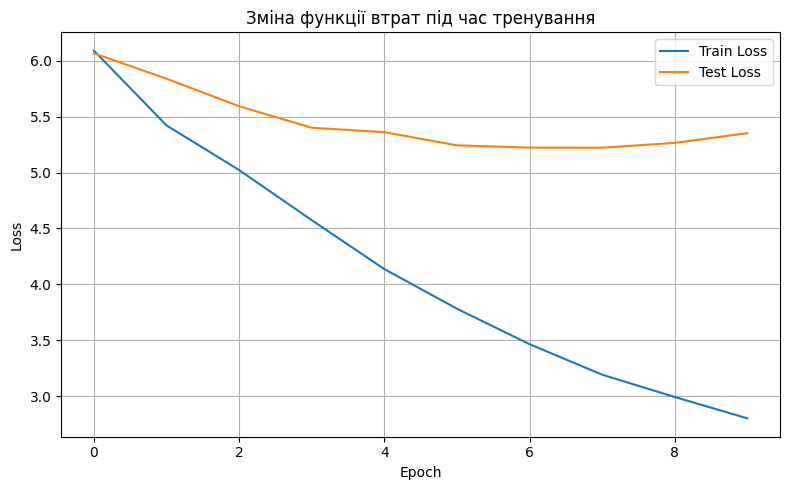

In [39]:
n_epochs = 10
clip = 1.0 # gradient clipping
teacher_forcing_ratio = 0.5

best_test_loss = float("inf")

model_path = os.path.join(model_dir, 'en_it.pt')
train_losses = []
test_losses = []

if os.path.exists(model_path):
    print("✅ Model already exists. Skipping training.")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
else:
    print("🚀 Starting training from scratch.")

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

    for epoch in tqdm(range(n_epochs)):

        train_loss = train_fn(
            model,
            train_data_loader,
            optimizer,
            criterion,
            clip,
            teacher_forcing_ratio,
            device,
        )

        test_loss = evaluate_fn(
            model,
            test_data_loader,
            criterion,
            device,
        )

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            torch.save(model.state_dict(), model_path)

        print(f"\tTrain Loss: {train_loss:7.3f}")
        print(f"\tTest Loss: {test_loss:7.3f}")

    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Зміна функції втрат під час тренування")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [40]:
model.load_state_dict(torch.load(os.path.join(model_dir, 'en_it.pt'), map_location=device))

test_loss = evaluate_fn(model, test_data_loader, criterion, device)

print(f"Test Loss: {test_loss:.3f}")

Test Loss: 5.222


In [41]:
def translate_sentence(
    sentence,
    model,
    en_nlp,
    it_nlp,
    en_vocab,
    it_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    model.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            en_tokens = [token.text for token in en_nlp.tokenizer(sentence)]
        else:
            en_tokens = [token for token in sentence]
        if lower:
            en_tokens = [token.lower() for token in en_tokens]
        en_tokens = [sos_token] + en_tokens + [eos_token]
        ids = en_vocab.lookup_indices(en_tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        encoder_outputs, hidden = model.encoder(tensor)

        inputs = it_vocab.lookup_indices([sos_token])
        attentions = torch.zeros(max_output_length, 1, len(ids))
        for i in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, attention = model.decoder(inputs_tensor, hidden, encoder_outputs)
            attentions[i] = attention
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == it_vocab[eos_token]:
                break
        it_tokens = it_vocab.lookup_tokens(inputs)
    return it_tokens, en_tokens, attentions[:len(it_tokens)-1]

In [42]:
def plot_attention(sentence, translation, attention):
    fig, ax = plt.subplots(figsize=(5,5))
    attention = attention.squeeze(1).numpy()
    cax = ax.matshow(attention, cmap="bone")
    ax.set_xticks(ticks=np.arange(len(sentence)), labels=sentence, rotation=90, size=15)
    translation = translation[1:]
    ax.set_yticks(ticks=np.arange(len(translation)), labels=translation, size=15)
    plt.show()
    plt.close()

In [43]:
test_data[0]

{'en_ids': tensor([   2,  319,  693,   43,  344,    5,  608,   73,    0,    0,    5, 1774,
          102,    5,  255,   11, 4136,  784, 1865,    5,   40,    7,   21, 1686,
           19,   30,  156,    5,    7, 7046,  205,   11,  960,  332,   16,    3]),
 'it_ids': tensor([    2,   886,     0,    30,    77,     0,     0,    30,   418,    56,
          5081,    30,   310,   228,  3478,    28,   913, 10810,    30,    11,
           530,  2202,   124,   900,   167,    30,  1059,  5627,   702,  5528,
           492,   356,  1299,    15,     3]),
 'translation': {'en': 'Great men of State, such as Yitzhak Rabin, understood this, but the Israeli peace forces, who are a credit to that country, are marginalised by the current regime.',
  'it': "Grandi statisti, come Yitzhak Rabin, lo hanno compreso, ma le forze di pace israeliane, che fanno onore a quel paese, vengono messe ai margini dall'attuale governo."},
 'en_tokens': ['<sos>',
  'great',
  'men',
  'of',
  'state',
  ',',
  'such',
  'as

In [44]:
sentence = test_data[100]["translation"]["en"]
expected_translation = test_data[100]["translation"]["it"]

sentence, expected_translation

('We face increased polarisations that come up against a backdrop of growing tensions over a series of political issues and of growing cultural stereotypes.',
 'Ci confrontiamo con una crescente polarizzazione che nasce in un contesto di crescenti tensioni su questioni politiche e stereotipi culturali sempre più presenti.')

In [45]:
import re

def tokens_to_sentence(tokens, sos_token="<sos>", eos_token="<eos>", unk_token="<unk>"):
    # Видаляємо sos/eos і замінюємо unk на пробіл
    cleaned = []
    for t in tokens:
        if t in {sos_token, eos_token}:
            continue
        elif t == unk_token:
            cleaned.append(" ")
        else:
            cleaned.append(t)

    sentence = ' '.join(cleaned)
    sentence = re.sub(r'\s+([?.!,;:])', r'\1', sentence)  # прибирає пробіли перед пунктуацією
    sentence = re.sub(r'\s{2,}', ' ', sentence)           # замінює подвійні пробіли на один
    return sentence.strip()

In [46]:
translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model,
    en_nlp,
    it_nlp,
    en_vocab,
    it_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

print(tokens_to_sentence(translation, sos_token, eos_token))
print(tokens_to_sentence(sentence_tokens, sos_token, eos_token))

la convenzione più forte sono sono nonché difendiamo che sono creare non che che difendiamo che che compiacenza sud europa che compiacenza
we face increased polarisations that come up against a backdrop of growing tensions over a series of political issues and of growing cultural stereotypes.


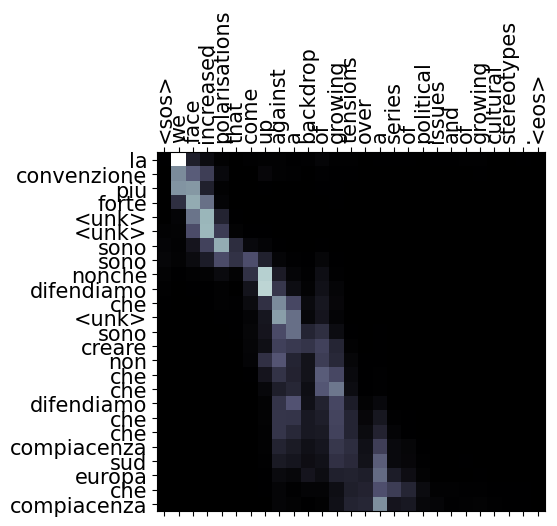

In [47]:
plot_attention(sentence_tokens, translation, attention)

### Аналіз результатів моделі Seq2Seq з увагою

##### 1. Графік функції втрат

- `Train Loss` **стабільно знижується** з кожною епохою — це свідчить про ефективне навчання.
- `Test Loss` спочатку знижується, потім **вирівнюється**, а наприкінці **незначно зростає**.
- Така поведінка вказує на **початок перенавчання** (overfitting) після ~7 епох.

---

##### 2. Експерименти з параметрами

- Під час тренування я пробував збільшити `teacher_forcing_ratio` до **0.75**, однак це **значно погіршило модель**, яка почала швидко перенавчатись і на тестових даних показувала **гірші результати**.
- Найбільш вдалим рішенням було додати **Dropout** до **енкодера** і **декодера** — це помітно покращило узагальнюючу здатність моделі.

---

##### 3. Візуалізація механізму уваги

- **Діагональний слід** уваги свідчить про **послідовне вирівнювання** слів у перекладі — це типово для простих речень із однаковим порядком.
- Декілька `<unk>` токенів у виході свідчать про **обмеження словника** і **відсутність потрібних слів у `it_vocab`**. Оскільки ми використовували лише 3% даних для тренування
- Слова, як-от `difendiamo`, `compiacenza`, отримують чіткий фокус уваги — модель явно навчається відповідним звʼязкам.

##### Висновок:

- Механізм уваги працює коректно й загалом вирівнює слова адекватно.
- Для покращення варто:
  - Запустити тренування на більшому датасеті щоб збільшити словник
  - Перевірити, можливо знизити  teacher_forcing_ratio до 30% щоб не допускати раннього перенавчання

- Навіть на **невеликому обсязі даних** модель демонструє хороші результати.
Якщо запустити тренування на **повному датасеті**, є підстави очікувати **значно кращу якість перекладу**.

---